In [89]:
#imports
try:
    from google.colab import drive
    #mount drive, set base path
    drive.mount("/gdrive")
    base_path = '/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites'
except:
    base_path = './'
from pathlib import Path
import matplotlib.pyplot as plt
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image


./


In [8]:
#dataset paths
#set these paths and file names depending on where you are and which labels you are using

data_path = Path(base_path).joinpath('processed/')
train_images_path = Path(data_path).joinpath('training_images_rand4_unique.npy')
train_labels_path = Path(data_path).joinpath('training_objcounts_rand4_unique.npy')
val_images_path = Path(data_path).joinpath('validation_images_rand4_unique.npy')
val_labels_path = Path(data_path).joinpath('validation_objcounts_rand4_unique.npy')

In [76]:
#load the numpy dataset files
train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path).astype(int)
val_images = np.load(val_images_path)
val_labels = np.load(val_labels_path).astype(int)


In [77]:
# change labels so that they start at 0
# TODO this is only valid for counts - so we need a flag for this or change the generator or dataloader appropriately
train_labels = (train_labels - 1)
val_labels = (val_labels - 1)
print(train_labels, val_labels)

[2 0 3 ... 1 0 3] [3 3 2 ... 3 2 1]


In [64]:
#convert labels to one-hot format
#template = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
#tmp_labels = np.zeros_like()
#train_labels = np.array([template[i] for _, i in enumerate(train_labels)])
#val_labels = np.array([template[i] for _, i in enumerate(val_labels)])
#print(train_labels)
#print(val_labels)

[[0 0 1 0]
 [0 0 0 0]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 1]]
[[0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


Text(0.5, 1.0, 'count: 3')

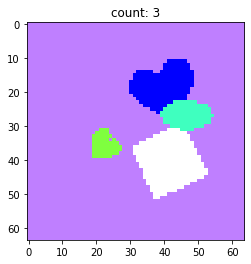

In [78]:
#examine data
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('count: ' + str(train_labels[idx]))

In [79]:
#utility functions for:
# setting the seed
# ensuring randomness of worker in data loader (overkill?)
# setting the device based on GPU availability

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [80]:
#define the dataset class for our data for use by the dataloader
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x, y

    def __len__(self):
        return len(self.img_labels)

In [81]:
#instantiate the dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=transforms.ToTensor())

In [90]:
#instantiate the dataloaders

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           num_workers=16,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=BATCH_SIZE,
                                         num_workers=16,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [91]:
#define the train and test loops, and a wrapper that will call them to train and collect validation stats

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current inpur model using the data
  from Train_loader and Updates parameters for a single pass
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    #print("target")
    #print(target)
    #print("output")
    #print(output)
    if reg_function1 is None:
      loss = criterion(output, target)
    elif reg_function2 is None:
      loss = criterion(output, target)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  """
  Tests the current Model
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):
  """
  Trains the model with train_loader and tests the learned model using val_loader
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, device=device)
    val_acc = test(trained_model, val_loader, device=device)
    # param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    # param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, trained_model

In [92]:
#define the MLP model
class AnimalNet(nn.Module):
  def __init__(self):
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 64 * 64, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

Random seed 2021 has been set.



Time to memorize the dataset: 835.4173336029053


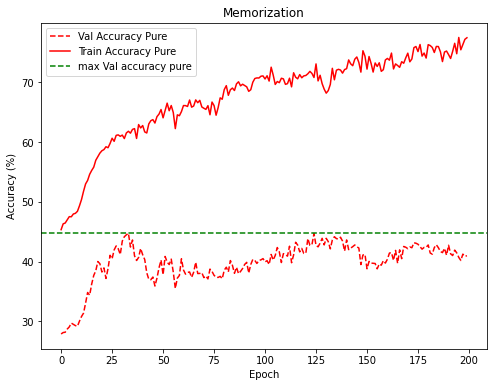

In [93]:
#set the hyper parameters, run the training and plot results
# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}


# Initialize the network
set_seed(seed=SEED)
model = AnimalNet()

start_time = time.time()
# Train the network
val_acc_pure, train_acc_pure, model = main(args=args,
                                              model=model,
                                              train_loader=train_loader,
                                              val_loader=val_loader)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()